<a href="https://colab.research.google.com/github/Ritwik-1/Fine-Tune-SAM/blob/master/SAM_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install git+https://github.com/facebookresearch/segment-anything.git

# FINE TUNE APPROACH 1 

In [2]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

model_checkpoint = "/content/drive/MyDrive/Colab Notebooks/assets/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint = model_checkpoint)


**FREEZING ALL IMAGE ENCODER PARAMS**

In [3]:
print(type(sam))

# Freezed all the Image encoder parameters 
for param in sam.image_encoder.parameters():
    param.requires_grad = False

<class 'segment_anything.modeling.sam.Sam'>


PARAMS IN PROMPT ENCODER

In [4]:
# IDEA : FREEZE THE POINT AND TEXT PROMPTS 
# BUT WHOLE MODULE HAS SUCH LESS PARAMS 

prompt_params = 0

for name,param in sam.prompt_encoder.named_parameters():
    # print(name)
    # print(param)
    prompt_params += param.numel()

print(prompt_params)

# Bas 6220?


6220


PARAMS IN IMAGE ENCODER

In [5]:
image_params = 0

for name,param in sam.image_encoder.named_parameters():
    # print(name)
    # print(param)
    image_params += param.numel()

print(image_params)


637026048


PARAMS IN MASK DECODER

In [6]:
mask_params = 0

for name,param in sam.mask_decoder.named_parameters():
    # print(name)
    # print(param)
    mask_params += param.numel()

print(mask_params)

4058340


In [7]:
trainable_params = 0
non_trainable_params = 0

# parameters are tensors , for getting actual no. of parameters we need to 
# count the no. of elements in each tensor 
# which is done using numel() function

for i in sam.parameters():
    if(i.requires_grad == False):
        # print(name)
        non_trainable_params+=i.numel()
    else:
        trainable_params+=i.numel()

print("Trainable params : ",trainable_params)
print("Non-trainable params : ",non_trainable_params)

Trainable params :  4064560
Non-trainable params :  637026048


**TO ADD MORE MLP LAYERS TO THE MASK DECODER**

In [ ]:
# for name,param in sam.mask_decoder.named_parameters():
#     print(name)

for name,param in sam.mask_decoder.named_parameters():
  #  if(name == 'MLP'):
      print(name)


In [ ]:
for name in sam.mask_decoder.children():
  #  if(name == 'MLP'):
      print(name)


In [ ]:
for i in range(4):
  for j in range(3):
     print(sam.mask_decoder.output_hypernetworks_mlps[i].layers[j].weight.shape)
     print(sam.mask_decoder.output_hypernetworks_mlps[i].layers[j].bias.shape)
     print("lol")

In [11]:
# Adding another MLP to the IoU prediction 

# DO NOT RUN AGAIN

import torch.nn as nn

additional_layer2 = nn.Linear(in_features=256, out_features=256,bias = True)

sam.mask_decoder.iou_prediction_head.layers.insert(1,additional_layer2)

In [ ]:
for name in sam.mask_decoder.children():
      print(name)

In [ ]:
# Checking dimensions again :
for i in range(4):
     print(sam.mask_decoder.iou_prediction_head.layers[i].weight.shape)
     print(sam.mask_decoder.iou_prediction_head.layers[i].bias.shape)
     print("lol")

In [ ]:
# ADDING MLPs to THE OUTPUT_HYPERNETWORKS MLP MODULE

# DO NOT RUN AGAIN 

module = sam.mask_decoder.output_hypernetworks_mlps

for i in range(4):
    lin_layer = nn.Linear(in_features=256, out_features=256,bias = True)
    module[i].layers.insert(1,lin_layer)

print(module)

In [ ]:
for name in sam.mask_decoder.children():
      print(name)

In [ ]:
for i in range(4):
  for j in range(4):
     if(j == 2):
      print("This is added layer")
     print(sam.mask_decoder.output_hypernetworks_mlps[i].layers[j].weight.shape)
     print(sam.mask_decoder.output_hypernetworks_mlps[i].layers[j].bias.shape)

In [17]:
# SAVING THE MODEL IN THIS CONFIGURATION

# i.e 1) Image encoder is freezed 
    # 2) added 1 more MLP layer to the final output predictions

  # for now

  # Now moving to training

import torch

torch.save(sam,'/content/drive/MyDrive/SAM_FT1/sam.pt')

# torch.save(sam.state_dict(), '/content/drive/MyDrive/SAM_FT1/sam.pth')

In [3]:
# Loading the model
import torch
sam_loaded = torch.load('/content/drive/MyDrive/SAM_FT1/sam.pt')


In [4]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

model_checkpoint = "/content/drive/MyDrive/Colab Notebooks/assets/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam_original = sam_model_registry[model_type](checkpoint = model_checkpoint)

In [5]:
import torch 
from segment_anything import SamPredictor

# device = "cuda"

# sam_loaded.to(device=device)

# sam_original.to(device = device)

predictor_loaded = SamPredictor(sam_loaded)

predictor_original = SamPredictor(sam_original)
# Now take only 1 patient and make 1 train and one label

# train to pada hi hai direct and for
# test : take mask and uska box banane ki try kar
# then uska sam se pass kara and dekh output loss kya aata hai

# taking the loss function they have used for their calc

# Then if sab sahi then move to training loop and train the full set 
# and visualize on tensorboard

# DATASET PREPARATION

In [19]:
from google.colab.patches import cv2_imshow

In [6]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.2 MB/s eta 0:00:00


# RUNNING ON ONLY 1 EXAMPLE

**Trying to run on 1 image/label first**

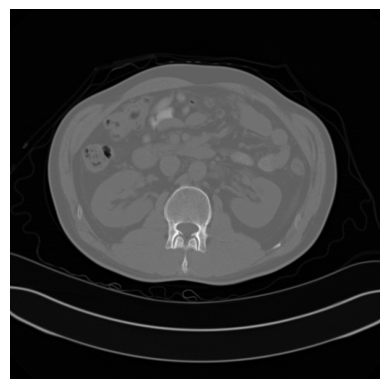

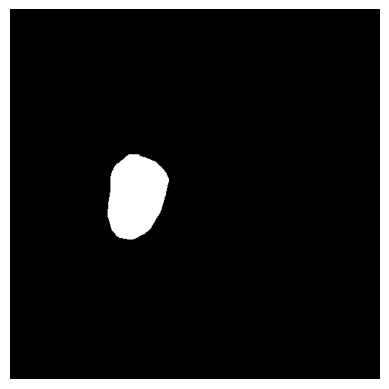

In [7]:
import cv2
import pydicom
import matplotlib.pyplot as plt

# First patient ki 35th slice of CT
test_image = "/content/drive/MyDrive/manifest-1680809675630/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_001/08-22-2000-NA-CT ABDOMEN-56266/2.000000-Pre Abd 5.0 B40f-18492/1-35.dcm"

# Taking the 35th segmentation from this
label_seg = "/content/drive/MyDrive/manifest-1680809675630/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_001/08-22-2000-NA-CT ABDOMEN-56266/300.000000-Segmentation-33545/1-1.dcm"


dicom_image = pydicom.dcmread(test_image)
pixel_data = dicom_image.pixel_array


plt.imshow(pixel_data, cmap='gray')
plt.axis('off')  
plt.show()

dicom_image_labels = pydicom.dcmread(label_seg)
pixel_data_labels = dicom_image_labels.pixel_array

plt.imshow(pixel_data_labels[35], cmap='gray')
plt.axis('off') 
plt.show()



**SEEING SHAPES OF BOTH THE IMAGES**

In [8]:
test_CT_image = pixel_data
label_CT_seg = pixel_data_labels[35]

print(test_CT_image.shape)
print(label_CT_seg.shape)

(512, 512)
(512, 512)


**GETTING THE BOUNDING BOX OF THE SEG
IN THE 512x512 plane**

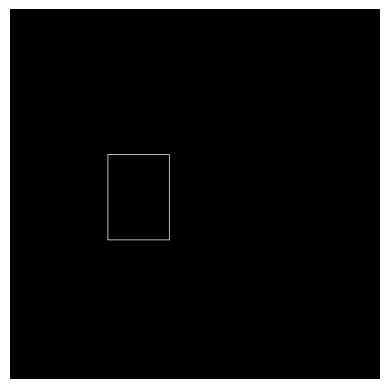

[(135, 201, 220, 319)]


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

threshold = 0  # Choose an appropriate threshold value
binary_mask = (label_CT_seg > threshold).astype(np.uint8)

# Find contours of the binary mask
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank 512x512 plane
plane = np.zeros((512, 512), dtype=np.uint8)

# Iterate over the contours and compute the bounding box coordinates
bounding_boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    bounding_boxes.append((x, y, x + w, y + h))
    
    # Plot the bounding box on the plane
    cv2.rectangle(plane, (x, y), (x + w, y + h), (255, 255, 255), 1)

# Plot the plane with bounding boxes
plt.imshow(plane, cmap='gray')
plt.axis('off')
plt.show()


print(bounding_boxes)

In [ ]:
# Now have the box , image , can produce the mask and also have the label can calc loss

import cv2
import numpy as np

image_jpg = cv2.cvtColor(test_CT_image, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR (OpenCV default format)
cv2.imwrite('image.jpg', image_jpg)  # Save the JPEG image

# Read JPEG image and convert it back to NumPy array
image_loaded = cv2.imread('image.jpg')  # Read the JPEG image
image_np_loaded = cv2.cvtColor(image_loaded, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

test_CT_image = image_np_loaded

In [14]:
predictor_original.set_image(test_CT_image)

In [28]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    return mask_image 

<class 'numpy.ndarray'>


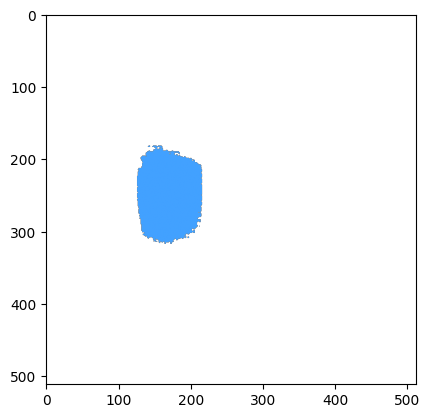

In [31]:
input_box = np.array(bounding_boxes[0])

masks, _, _ = predictor_original.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

print(type(masks))

mask_image = show_mask(masks[0], plt.gca())

ax = plt.gca()
ax.imshow(mask_image)

# START OF FULL DATASET CREATION

(61, 512, 512)
(512, 512)


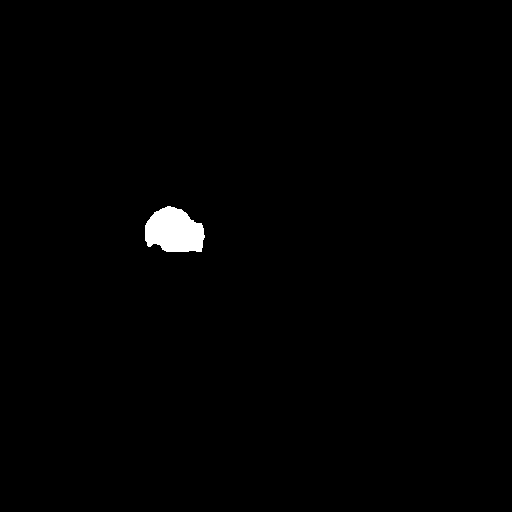

In [ ]:
import pydicom
import numpy as np
import cv2

# Load the DICOM file
dcm = pydicom.dcmread("/content/drive/MyDrive/Colab Notebooks/assets/Patient-1-seg.dcm")

# Extract the pixel data
pixel_array = dcm.pixel_array

print(pixel_array.shape)

p = pixel_array[28]  # Extract the first channel

print(p.shape)

normalized_array = ((p - np.min(p)) / np.ptp(p) * 255).astype(np.uint8)
bgr_image = cv2.cvtColor(normalized_array, cv2.COLOR_GRAY2BGR)

cv2_imshow(bgr_image)
# Normalize the pixel values
# normalized_array = ((pixel_array - np.min(pixel_array)) / np.ptp(pixel_array) * 255).astype(np.uint8)

# # Convert to BGR format (assuming the segmentation map is grayscale)
# bgr_image = cv2.cvtColor(normalized_array, cv2.COLOR_GRAY2BGR)

(512, 512)
(512, 512)


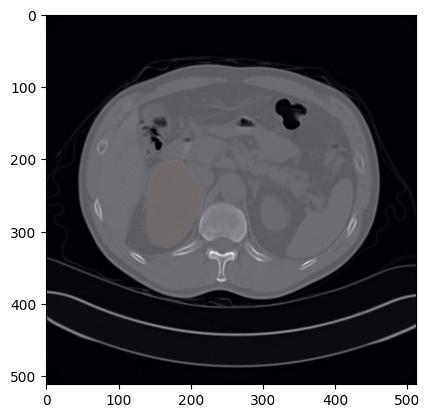

In [ ]:
import pydicom
import matplotlib.pyplot as plt

# Load the DICOM image
dcm = pydicom.dcmread("/content/drive/MyDrive/Colab Notebooks/assets/1-25.dcm")

dcm_2 = pydicom.dcmread("/content/drive/MyDrive/Colab Notebooks/assets/Patient-1-seg.dcm")
# Get the pixel data
pixels = dcm.pixel_array
p = dcm_2.pixel_array

print(p[25].shape)
print(pixels.shape)

# Display the image using matplotlib
plt.imshow(pixels, cmap=plt.cm.gray)
plt.imshow(p[36], cmap='jet', alpha=0.05) # interpolation='none'
plt.show()

